In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DAT_POT1 = 1.631e+20
DAT_POT2 = 2.750e+20
DAT_POT3 = 2.291e+20

DAT_POT1 = 1.69E+20
DAT_POT2 = 2.73E+20
DAT_POT3 = 2.44E+20

In [2]:
def MakeBDTcut(idf,sigcut,mode,nBDTs,r2overlay=False,ttc=0.1):
    
    # Conglemerate BDT scores and weights based on strategy 
    
    bdtweight = np.zeros(idf.shape[0])
    sigprobmax = np.zeros(idf.shape[0]) 
    sigprobavg = np.zeros(idf.shape[0])
    sigprobmedian = np.zeros(idf.shape[0])
    sigproblist = np.zeros((idf.shape[0],nBDTs))
    notintrain = np.zeros((idf.shape[0],nBDTs),dtype=bool)
    numnottrain = np.zeros(idf.shape[0])
    for b in range(nBDTs):
        sp = idf['sigprob%i'%b]
        tvw = idf['tvweight%i'%b]
        sigprobmax = np.where(np.logical_and(tvw>0,sp>sigprobmax),sp,sigprobmax) # cut on the maximum non-train score in ensemble
        if mode == 'fracweight': 
            #bdtweight += np.where(sp>sigcut,tvw/float(nBDTs),0)
            bdtweight += np.where((tvw>ttc) & (sp>sigcut),1.0,0.0)
        sigprobavg += np.where(tvw>ttc,sp,0)
        numnottrain += np.where(tvw>ttc,1,0)
        sigproblist[:,b] = sp
        notintrain[:,b] = tvw > ttc
    sigprobavg /= np.where(numnottrain>0,numnottrain,1)
    for i,(tlist,siglist) in enumerate(zip(notintrain,sigproblist)):
        splist = siglist[tlist]
        if splist.size!=0: sigprobmedian[i] = np.median(splist)
        else: sigprobmedian[i] = 0
        
    idf['sigprobavg'] = sigprobavg
    idf['sigprobmedian'] = sigprobmedian
    idf['sigprobmax'] = sigprobmax

    
    if mode == 'avgscore':
        idf['sigprob'] = idf['sigprobavg']
        bdtweight = np.where(sigprobavg>sigcut,1,0)
    elif mode == 'medianscore':
        idf['sigprob'] = idf['sigprobmedian']
        bdtweight = np.where(sigprobmedian>sigcut,1,0)
    elif mode == 'fracweight':
        idf['sigprob'] = idf['sigprobmax']
        bdtweight /= np.where(numnottrain>0,numnottrain,1)
    
    idf['bdtweight'] = bdtweight
    
    # Drop duplicates
    
    idf.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
    if r2overlay:
        idf.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
    else:
        idf.drop_duplicates(subset=['run','subrun','event'],inplace=True)

In [3]:
dfs = {1:{},2:{},3:{}}
pot = {1:{},2:{},3:{}}

dfs[1]['intrin'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_intrinsics_fset11_run1.parquet.gzip')
dfs[1]['overlay'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_overlay_fset11_run1.parquet.gzip')
dfs[1]['ext'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_ext_fset11_run1.parquet.gzip')
dfs[1]['ncpi0'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_ncpi0_fset11_run1.parquet.gzip')
dfs[1]['ccpi0'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_ccpi0_fset11_run1.parquet.gzip')

dfs[2]['intrin'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_intrinsics_fset11_run2.parquet.gzip')
dfs[2]['overlay'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_overlay_fset11_run2.parquet.gzip')

dfs[3]['intrin'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_intrinsics_fset11_run3.parquet.gzip')
dfs[3]['overlay'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_overlay_fset11_run3.parquet.gzip')
dfs[3]['ext'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_ext_fset11_run3.parquet.gzip')
dfs[3]['ncpi0'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_ncpi0_fset11_run3.parquet.gzip')
dfs[3]['ccpi0'] = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_ccpi0_fset11_run3.parquet.gzip')

for k in dfs[1].keys(): pot[1][k] = DAT_POT1
for k in dfs[2].keys(): pot[2][k] = DAT_POT2
for k in dfs[3].keys(): pot[3][k] = DAT_POT3
pot[3]['ext'] = DAT_POT2+DAT_POT3

In [6]:
num = 0
dftot = pd.DataFrame()
for r in [1,2,3]:
    for k in dfs[r].keys():
        dfc = dfs[r][k].copy()
        MakeBDTcut(dfc,0.95,'avgscore',20,r==2 and k=='overlay')
        dfc = dfc.query('oldBDTscore<0.7 and sigprob>0.95')
        dfc['weights'] = dfc['GenieWeight']/dfc['POTweight']*pot[r][k]
        dfc['weights'] *= dfc['Enu_1e1p']<1200
        dfc['weights'] *= dfc['Enu_1e1p']>700
        dftot = pd.concat((dftot,dfc))
        num += sum(np.array(dfc['weights']))
        
print(num)

1.6777204254950355


{1000: 0.30577863124736715, 1091: 0.029313213525238975, 1003: 0.1126326006982528, 1004: 0.03220496878537793, 1005: 0.01849011481552591}


/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


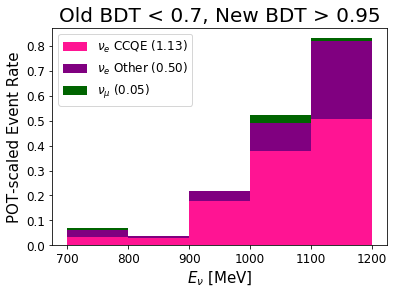

In [7]:
dfsig = dftot.query('label == \'nue_ccqe\'')
dfnuebkg = dftot.query('label == \'nue_other\'')
nuebkgrate = {}
for ev in np.array(dfnuebkg.query('weights>0')[['interactionType','weights']]):
    if int(ev[0]) not in nuebkgrate.keys(): nuebkgrate[int(ev[0])] = ev[1]
    else: nuebkgrate[int(ev[0])] += ev[1]
print(nuebkgrate)
pipm = []
for mode in dfnuebkg['interactionType']:
    pipm.append(mode in [1003,1005,1007,1009,1010,1012,1014,1016,1017,1021,1028,1032,1079,1085])
dfnuebkg['pipm'] = pipm
dfnumubkg = dftot.query('label != \'nue_other\' and label != \'nue_ccqe\'')

hists = [dfsig['Enu_1e1p'],
         #dfnuebkg.query('pipm')['Enu_1e1p'],
         dfnuebkg['Enu_1e1p'],
         dfnumubkg['Enu_1e1p']]
weights = [dfsig['weights'],
           #dfnuebkg.query('pipm')['weights'],
           dfnuebkg['weights'],
           dfnumubkg['weights']]
cls = ['deeppink','purple','darkgreen']


n,_,_ = plt.hist(hists,weights=weights,range=(700,1200),bins=5,stacked=True)
plt.clf()
labels = [r'$\nu_e$ CCQE (%2.2f)'%sum(n[0]),
          #r'$\nu_e$ $\pi^\pm$ (%2.2f)'%(sum(n[1])-sum(n[0])),
          r'$\nu_e$ Other (%2.2f)'%(sum(n[1])-sum(n[0])),
          r'$\nu_\mu$ (%2.2f)'%(sum(n[2])-sum(n[1]))]
plt.hist(hists,weights=weights,label=labels,range=(700,1200),bins=5,color=cls,stacked=True)
plt.xlabel(r'$E_\nu$ [MeV]',fontsize=15)
plt.ylabel('POT-scaled Event Rate',fontsize=15)
plt.title('Old BDT < 0.7, New BDT > 0.95',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

(array([0.        , 0.        , 0.05250961]),
 array([0.7, 0.8, 0.9, 1. ]),
 <a list of 3 Patch objects>)

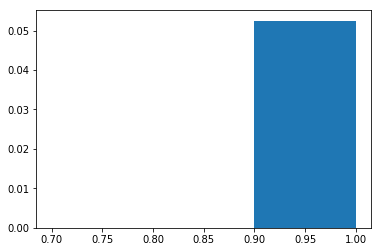

In [73]:
plt.hist(dfnumubkg['sigprob'],range=(0.7,1.0),bins=3,weights=dfnumubkg['weights'])